In [1]:
import os
import sys
import time
import io

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as tdata
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tqdm.notebook import tqdm
import wandb

In [9]:
from anime_face_generator.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, MODELS_DIR, FIGURES_DIR
import anime_face_generator.modeling.models.simple_unet_ddpm_49M as Simple
from anime_face_generator.modeling.train import train_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


![Algorithm1](https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models_DDPM_trainig_inference_algorithm-1024x247.png)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("number of GPUs:", torch.cuda.device_count())

Using device: cuda
number of GPUs: 2


## Data augmentation

In [11]:
# transformers = torchvision.transforms.Compose([
#     torchvision.transforms.Resize(size=Simple.ModelParams.im_size),
#     torchvision.transforms.RandomHorizontalFlip(),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
# ])

# dataset = torchvision.datasets.ImageFolder(root=PROCESSED_DATA_DIR, transform=transformers, target_transform=None)

In [12]:
rand_gen = torch.Generator().manual_seed(1978)

## Unet Denoiser Architecture

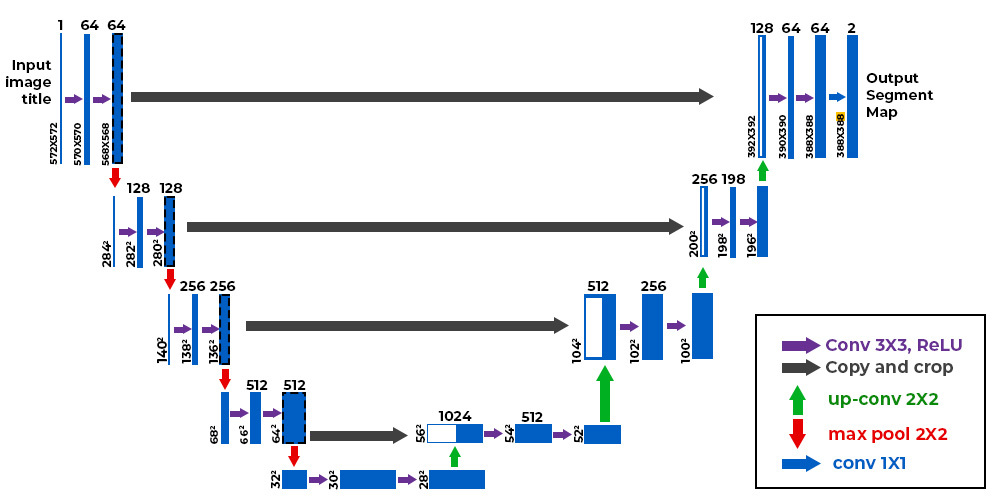

In [15]:
# torch.cuda.empty_cache()
# giga_model_trained = train_model(module=Simple, dataset=dataset, device=device, rand_gen=rand_gen, wandb_logs=True)

---------------------------------------------
 EPOCH 1
---------------------------------------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 10.90 GiB of which 237.12 MiB is free. Including non-PyTorch memory, this process has 10.67 GiB memory in use. Of the allocated memory 10.22 GiB is allocated by PyTorch, and 291.85 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Simpling from the learned distribution

In [11]:
def show_images_grid_rgb(samples, nrow=8, ncol=6, epoch=0):
    fig, axes = plt.subplots(ncol, nrow, figsize=(nrow, ncol))
    samples = (samples + 1) / 2         # Rescale from [-1, 1] to [0, 1]
    samples = samples.clamp(0, 1).cpu() # Ensure valid pixel range
    samples = samples.permute(0, 2, 3, 1)  #(N, H, W, C) for plotting

    idx = 0
    for row in range(ncol):
        for col in range(nrow):
            if idx == samples.shape[0]:
                break
            axes[row, col].imshow(samples[idx])
            axes[row, col].axis('off')
            idx += 1
    plt.tight_layout()
    plt.title(f"Simple in epoch{epoch}")
    fig_name = str(model_backup)[0:-4] + '_epoch_'+ str(epoch) +'_samples.png'
    plt.savefig(FIGURES_DIR / fig_name, format='png')
    plt.show()

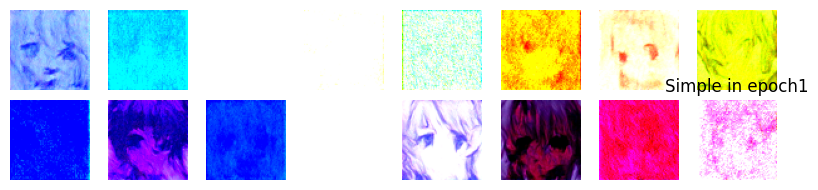

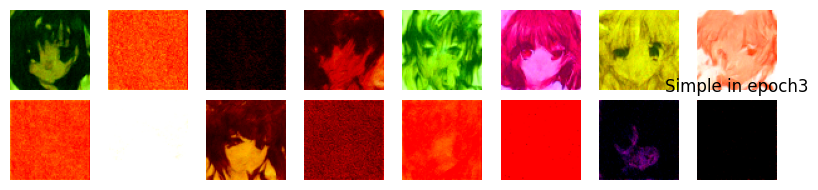

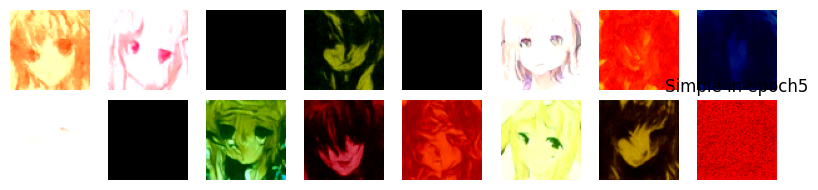

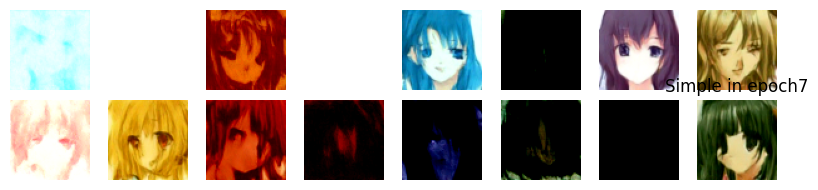

Number of trainable parameters: 48.98M


In [12]:
model = Simple.NoisePredictor()
reverse_diffusion = model.diffuser.reverse
backups = [
    "simple_unet_ddpm_49M_ckpt_epoch_1_2025-08-13_04-50-49.pth",
    "simple_unet_ddpm_49M_ckpt_epoch_3_2025-08-13_10-10-46.pth",
    "simple_unet_ddpm_49M_ckpt_epoch_5_2025-08-13_15-33-49.pth",
    "simple_unet_ddpm_49M_ckpt_epoch_7_2025-08-13_20-54-54.pth"
]
epochs = [1,3,5,7]

for i in range(4):
    
    model_backup =  backups[i]
    model.load_parameters(path=MODELS_DIR / model_backup)

    model = model.to(device)
    samples = model.generate_samples(num_samples=16)
    show_images_grid_rgb(samples, nrow=8, ncol=2, epoch=epochs[i])

num_model_params = model.get_num_trainable_parameters()
print(f"Number of trainable parameters: {num_model_params / 1e6:.2f}M")

 ### Saving the notebook.

In [ ]:
from ipylab import JupyterFrontEnd
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')